# Entrenar un robot utilizant NEAT

## Introducció

En aquest notebook, entrenarem un robot perquè seguisca un camí fins a la destinació. Utilitzarem NEAT (NeuroEvolution of Augmenting Topologies) per aconseguir-ho. NEAT és un algorisme d'aprenentatge per reforçament quee utilitza xarxes neuronals per aconseguir el seu objectiu. Aquest algorisme és capaç de crear xarxes neuronals amb topologies molt complexes i eficients.
Partirem de les entrades i sortides de la xarxa neuronal, i l'algorisme s'encarregarà de trobar la millor topologia per aconseguir-ho.

## Preparar les llibreries

Utilitzarem les llibreries d'`aitk` i `neat-python` per aconseguir el nostre objectiu. Començarem instal·lant les llibreries necessàries.

In [1]:
!pip install aitk neat-python graphviz

In [2]:
import aitk.robots as bots
from aitk.utils import Grid
from aitk.algorithms import neat

import cv2
import requests
import matplotlib.pyplot as plt

## Neuroevolució

En aquest problema plantejarem les següents definicions:

- **Gen**: Un gen serà un node de la xarxa neuronal.
- **Cromosoma**: Un cromosoma serà una xarxa neuronal amb els pesos corresponents. El seu tamany serà el nombre de pesos de la xarxa neuronal.
- **Població**: Una població serà un conjunt de cromosomes.

El mon i el robot seran els mateixos que en el notebook anterior.

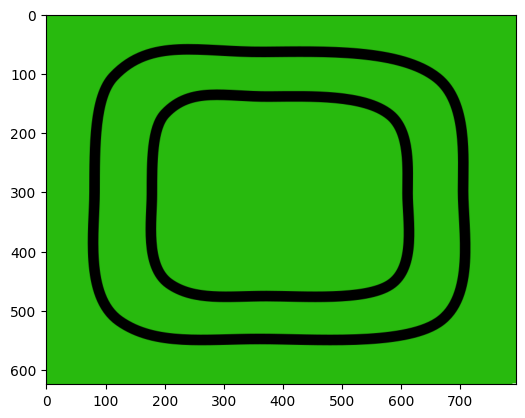

In [3]:
nom_imatge = "pista_6.png"

url = "https://lawer.github.io/mia/apunts/9.-Rob%C3%B3tica/" + nom_imatge

response = requests.get(url)

# Guardem la imatge

with open(nom_imatge, "wb") as f:
    f.write(response.content)

# Carreguem la imatge en una variable

img = cv2.imread(nom_imatge)

# Mostrem la imatge
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
world = bots.World(220, 180, boundary_wall_color="yellow", ground_image_filename=nom_imatge)

amplada_camera = 120
alcada_camera = 50
robot = bots.Scribbler(x=36, y=80, a=90)
robot.add_device(bots.GroundCamera(width=amplada_camera, height=alcada_camera))

world.add_robot(robot)

robot['ground-camera'].watch()
world.watch()

Random seed set to: 7472897


HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

HTML(value='<style>img.pixelated {image-rendering: pixelated;}</style>')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00x\x00\x00\x002\x08\x06\x00\x00\x00\x97\xa7\x1f\xd…

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

Per calcular el fitness de cada cromosoma, tindrem en compte la distància recorreguda pel robot. Si el robot surt de la matriu, el seu fitness serà 0.

Haurem d'implementar les següents funcions:

- `neat_controller`: Controlador per al robot. Aquí deurem buscar el centre de la imatge captada pel robot i passar-lo a la xarxa neuronal, per calcular el següent moviment i portar-lo a terme.
- `fitness`: Funció per calcular el fitness de cada cromosoma.

Per calcular el calcular el fitness ens poden resultar útils les següents funcions i classes:

- `aitk.utils.Grid`: Classe per a representar una matriu. Li passem el tamany i el mon que ha de monitoritzar. Vejam algunes de les seves funcions:
    - `grid.update(x, y)`: Actualitza l'estat d'una cel·la (per marcar-la com a visitada), 
    - `grid.analyze_visits()`: Calcula el percentatge de cel·les visitades - del 0 si no hi ha cap cel·la visitada, al 1 si ho estan totes.
    - `grid.draw()`: Mostra l'estat actual de la matriu. Ens serà molt útil per veure quines cel·les ha visita  t el robot i quines no i premiar aquells cromosomes que visiten més cel·les.
    - `grid.sequence`: Ens retorna una llista amb les cel·les visitades pel robot. Ens serà útil per calcular el fitness i saber si el robot ha donat la volta a la matriu.
- `robot.stalled`: Funció que ens indica si el robot està contra una paret o no. Ens serà útil per a calcular el fitness, perquè si el robot està aturat, el seu fitness serà 0. També podrem acabar l'entrenament si el robot està aturat.

- `world.time`: Variable que ens indica el temps que ha passat des de l'inici de l'entrenament. Ens serà útil per premiar aquells cromosomes que arriben abans a la destinació. 

In [5]:
def neat_controller(robot):
    # Controlador per a la xarxa neuronal
    # La xarxa estarà en robot.state["net"]
    # Deurem utilitzar la funció activate de la xarxa per a obtenir les sortides


def fitness(net, seconds=180, real_time=False):
    # Avalua el cromosoma i retorna el seu valor de fitness

    # La xarxa la guardem en el robot per a poder-la utilitzar en el controlador
    robot.state["net"] = net
    # Utilitzem una matriu de 10x10 per a guardar les visites del robot
    robot.state["grid"] = Grid((10, 10), robot.world)


En neat també hem de definir una funció de fitness per tot la població

In [19]:
def eval_population(pop, config):
    """Aquesta funció rebrà una població de cromosomes i els avaluarà"""
    for genome_id, genome in pop:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = fitness(net, 180, real_time=False)


Per ultim definirem com volem que funcioni el procés evolutiu

In [20]:
def run(config_file):
    # Load configuration
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    # Uncomment this to save checkpoints every 5 generations
    # p.add_reporter(neat.Checkpointer(5))

    winner = p.run(eval_population, 20)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))
    node_names = {-1:'d1', -2:'d2', -3:'d3', -4:'timer', 
                  -5:'stall', -6:'bias', 
                  0:'translate', 1: 'rotate'}
    neat.visualize.draw_net(config, winner, True, node_names=node_names)
    neat.visualize.plot_stats(stats, ylog=False, view=True)
    neat.visualize.plot_species(stats, view=True)
    
    return winner

In [21]:
%%writefile laberint.config
#--- parameters for the Robot Coverage experiment ---#

[NEAT]
fitness_criterion     = max
fitness_threshold     = # Introdueix un valor de fitness que penses que és suficient
pop_size              = # Quan més gran sigui la població, major variabilitat hi haurà a costa de més temps de càlcul
reset_on_extinction   = False

[DefaultGenome]
# node activation options
activation_default      = tanh
activation_mutate_rate  = 0.0
activation_options      = tanh

# node aggregation options
aggregation_default     = sum
aggregation_mutate_rate = 0.0
aggregation_options     = sum

# node bias options
bias_init_mean          = 0.0
bias_init_stdev         = 1.0
bias_max_value          = 30.0
bias_min_value          = -30.0
bias_mutate_power       = 0.5
bias_mutate_rate        = 0.7
bias_replace_rate       = 0.1

# genome compatibility options
compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient   = 0.5

# connection add/remove rates
conn_add_prob           = 0.5
conn_delete_prob        = 0.5

# connection enable options
enabled_default         = True
enabled_mutate_rate     = 0.01

feed_forward            = True
initial_connection      = full

# node add/remove rates
node_add_prob           = 0.2
node_delete_prob        = 0.2

# network parameters
num_hidden              = 0 # Es recomanable començar amb 0
num_inputs              = # Introdueix el nombre d'entrades al robot
num_outputs             = # Quants valors de sortida necessitem?

# node response options
response_init_mean      = 1.0
response_init_stdev     = 0.0
response_max_value      = 30.0
response_min_value      = -30.0
response_mutate_power   = 0.0
response_mutate_rate    = 0.0
response_replace_rate   = 0.0

# connection weight options
weight_init_mean        = 0.0
weight_init_stdev       = 1.0
weight_max_value        = 30
weight_min_value        = -30
weight_mutate_power     = 0.5
weight_mutate_rate      = 0.8
weight_replace_rate     = 0.1

[DefaultSpeciesSet]
compatibility_threshold = 3.0

[DefaultStagnation]
species_fitness_func = max
max_stagnation       = 20
species_elitism      = 2

[DefaultReproduction]
elitism            = 2
survival_threshold = 0.2

Overwriting laberint.config



 ****** Running generation 0 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 129.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 142.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 123.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 49.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 47.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.20; speed 195.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 166.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.00; speed 168.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 216.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:59.50; speed 225.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 167.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.40; speed 81.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:18.70; speed 177.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 116.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 77.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.90; speed 97.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 37.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 60.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 146.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.30; speed 67.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 100.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 192.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 128.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.50; speed 87.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 78.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 196.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 111.34 x real time
Population's average fitness: 4.12310 stdev: 19.42957
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.376, standard deviation 0.315
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    50     99.9    0.041     0
Total extinctions: 0
Generation time: 22.911 sec

 ****** Running generation 1 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 194.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:59.50; speed 226.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.50; speed 209.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.30; speed 114.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 52.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:18.70; speed 190.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 116.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.50; speed 193.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:21.00; speed 214.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 99.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 149.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 45.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 125.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.10; speed 140.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 98.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.00; speed 134.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 64.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 95.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.70; speed 116.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 32.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.20; speed 119.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.60; speed 126.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.60; speed 152.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:31.30; speed 159.1 x real time
Population's average fitness: 4.13130 stdev: 19.42813
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.144, standard deviation 0.351
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    50     99.9    0.041     1
Total extinctions: 0
Generation time: 22.324 sec (22.617 average)

 ****** Running generation 2 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 226.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:59.50; speed 254.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 131.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.00; speed 158.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 165.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 116.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 179.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 206.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.70; speed 108.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 114.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 115.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 94.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 137.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 107.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.40; speed 180.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:26.60; speed 209.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 109.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.90; speed 181.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:23.70; speed 218.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:20.20; speed 150.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 134.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 45.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:22.40; speed 210.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 130.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 159.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 217.99 x real time
Population's average fitness: 8.01937 stdev: 26.55253
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.146, standard deviation 0.338
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    2    50     99.9    0.080     2
Total extinctions: 0
Generation time: 23.033 sec (22.756 average)

 ****** Running generation 3 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 211.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:59.50; speed 224.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 162.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.40; speed 145.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 145.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:23.20; speed 214.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.50; speed 119.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 133.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 181.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 209.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:14.10; speed 225.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 89.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 172.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 55.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.70; speed 117.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.40; speed 165.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 97.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.00; speed 90.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 174.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:33.80; speed 231.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 188.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.40; speed 153.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 96.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 178.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 147.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.50; speed 95.92 x real time
Population's average fitness: 6.06131 stdev: 23.50792
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.046, standard deviation 0.368
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    3    50     99.9    0.061     3
Total extinctions: 0
Generation time: 22.129 sec (22.599 average)

 ****** Running generation 4 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 116.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:14.10; speed 242.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.10; speed 188.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:53.80; speed 170.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.40; speed 208.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 146.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:38.10; speed 176.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:33.30; speed 242.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 129.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 31.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 121.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.90; speed 198.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 140.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:25.80; speed 207.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 133.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:22.40; speed 201.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 143.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 169.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:25.40; speed 231.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:21.10; speed 210.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 107.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 94.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.40; speed 100.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.90; speed 135.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:17.90; speed 116.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 131.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 108.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 104.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.55 x real time
Population's average fitness: 7.94174 stdev: 26.49251
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.079
Mean genetic distance 1.024, standard deviation 0.363
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    4    50     99.9    0.079     4
Total extinctions: 0
Generation time: 20.486 sec (22.177 average)

 ****** Running generation 5 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 89.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:14.10; speed 239.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:30.40; speed 221.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:35.90; speed 222.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.80; speed 203.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 86.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.80; speed 132.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.80; speed 146.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:57.20; speed 237.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.20; speed 216.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.50; speed 190.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 154.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 79.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.90; speed 175.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 216.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 61.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 107.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 82.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 145.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:33.80; speed 162.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.90; speed 53.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.00; speed 117.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 184.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.50; speed 94.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 132.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 156.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 121.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.50; speed 112.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 196.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.31 x real time
Population's average fitness: 8.04914 stdev: 26.69042
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.081
Mean genetic distance 1.138, standard deviation 0.347
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    5    50     99.9    0.081     5
Total extinctions: 0
Generation time: 24.254 sec (22.523 average)

 ****** Running generation 6 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 185.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:30.40; speed 246.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.00; speed 160.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 216.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 52.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 163.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:38.20; speed 152.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 104.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:53.10; speed 161.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.90; speed 149.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.40; speed 209.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.40; speed 159.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 134.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.40; speed 110.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.60; speed 122.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 121.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 185.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 166.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.60; speed 163.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 206.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 112.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 208.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.80; speed 124.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:44.50; speed 177.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 187.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 115.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.50; speed 126.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 197.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 101.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.80; speed 138.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.50; speed 115.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.70; speed 197.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 135.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.20; speed 194.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 205.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 116.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.50; speed 162.22 x real time
Population's average fitness: 10.02309 stdev: 29.58163
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.100
Mean genetic distance 1.277, standard deviation 0.412
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    6    50     99.9    0.100     6
Total extinctions: 0
Generation time: 19.684 sec (22.117 average)

 ****** Running generation 7 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 223.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 251.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 114.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.20; speed 185.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 174.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 101.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.90; speed 163.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:33.10; speed 228.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 215.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.10; speed 138.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:22.20; speed 205.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 132.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.70; speed 184.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 173.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 132.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:31.40; speed 230.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:21.10; speed 213.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 127.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 102.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 100.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.60; speed 112.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:22.70; speed 223.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 80.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 98.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.60; speed 257.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 140.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.70; speed 180.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 135.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 115.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.50; speed 116.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 103.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 151.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.50; speed 117.36 x real time
Population's average fitness: 6.12286 stdev: 23.56504
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.179, standard deviation 0.346
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    7    50     99.9    0.061     7
Total extinctions: 0
Generation time: 17.696 sec (21.565 average)

 ****** Running generation 8 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 103.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 251.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 142.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:24.80; speed 223.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 141.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 135.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.70; speed 217.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 126.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 70.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 46.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 78.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 61.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 113.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 80.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 164.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.10; speed 217.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 110.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:41.60; speed 226.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 89.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 97.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.80; speed 193.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 144.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.00; speed 134.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 83.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 106.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 139.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.70; speed 142.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 137.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.40; speed 140.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:24.60; speed 209.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 128.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 120.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 52.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.74 x real time
Population's average fitness: 6.01338 stdev: 23.45325
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.060
Mean genetic distance 1.198, standard deviation 0.372
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    8    50     99.9    0.060     8
Total extinctions: 0
Generation time: 16.197 sec (20.968 average)

 ****** Running generation 9 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 136.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 243.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 140.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.70; speed 154.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 117.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:26.50; speed 159.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 162.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 109.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 92.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 84.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 216.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 175.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.90; speed 138.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 132.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 81.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 177.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 217.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 81.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 158.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.60; speed 90.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 126.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 136.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:49.20; speed 233.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.80; speed 182.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.60; speed 117.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 94.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 165.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 215.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 173.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:28.10; speed 187.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.90; speed 193.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 91.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:20.90; speed 209.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 204.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 95.45 x real time
Population's average fitness: 4.11969 stdev: 19.52881
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.197, standard deviation 0.397
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    9    50     99.9    0.041     9
Total extinctions: 0
Generation time: 20.579 sec (20.929 average)

 ****** Running generation 10 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 123.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 224.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 121.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 215.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.50; speed 163.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 212.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 94.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 92.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 127.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 203.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 143.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.40; speed 165.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.10; speed 137.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 165.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:19.10; speed 203.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.40; speed 83.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 189.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 194.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 102.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 211.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 132.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:21.60; speed 122.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 216.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 168.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 182.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.70; speed 160.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.50; speed 59.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 53.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.80; speed 103.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 85.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:14.00; speed 160.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.80; speed 181.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 129.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 215.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.30; speed 213.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 187.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:13.50; speed 193.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.70; speed 181.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 211.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.10; speed 160.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.28 x real time
Population's average fitness: 7.98833 stdev: 26.65115
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.243, standard deviation 0.428
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   10    50     99.9    0.080    10
Total extinctions: 0
Generation time: 21.185 sec (20.757 average)

 ****** Running generation 11 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 197.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 225.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 132.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 101.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 193.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:24.30; speed 194.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 136.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.90; speed 165.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:36.20; speed 164.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 195.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 210.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 81.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.90; speed 196.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 207.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:45.00; speed 185.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.10; speed 184.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 137.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 99.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 166.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 80.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.10; speed 161.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 125.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 105.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 93.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.70; speed 189.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.60; speed 83.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 82.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:50.20; speed 209.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 121.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 81.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:04.30; speed 192.94 x real time
Population's average fitness: 7.99538 stdev: 26.60039
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.310, standard deviation 0.463
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   11    50     99.9    0.080    11
Total extinctions: 0
Generation time: 22.115 sec (20.736 average)

 ****** Running generation 12 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 212.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 245.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 155.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 178.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.70; speed 148.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 118.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.10; speed 151.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.60; speed 172.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:05.10; speed 234.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 107.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:42.30; speed 233.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 77.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.40; speed 154.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 107.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 169.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:20.60; speed 190.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 112.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 71.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.50; speed 101.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.30; speed 129.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:13.30; speed 235.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.20; speed 162.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 136.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.50; speed 159.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.70; speed 219.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 136.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.30; speed 126.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 174.99 x real time
Population's average fitness: 7.98369 stdev: 26.61980
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.031, standard deviation 0.391
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   12    50     99.9    0.080    12
Total extinctions: 0
Generation time: 20.539 sec (20.486 average)

 ****** Running generation 13 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 161.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 236.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 142.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.60; speed 142.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 204.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:20.30; speed 205.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 101.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.00; speed 117.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 110.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.20; speed 100.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 138.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.50; speed 140.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 54.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 155.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.90; speed 174.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.50; speed 196.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 129.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 140.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:45.80; speed 224.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 93.27 x real time
Population's average fitness: 6.15530 stdev: 23.60642
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.062
Mean genetic distance 1.155, standard deviation 0.430
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   13    50     99.9    0.062    13
Total extinctions: 0
Generation time: 25.766 sec (20.850 average)

 ****** Running generation 14 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 140.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 252.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 143.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 81.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 105.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.90; speed 156.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 48.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 148.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:58.20; speed 249.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.10; speed 138.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:42.30; speed 220.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 101.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 121.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:47.50; speed 224.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.30; speed 209.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 136.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 190.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.00; speed 124.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.90; speed 205.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 87.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.60; speed 207.35 x real time
Population's average fitness: 6.11662 stdev: 23.43929
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.102, standard deviation 0.404
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   14    50     99.9    0.061    14
Total extinctions: 0
Generation time: 25.140 sec (21.315 average)

 ****** Running generation 15 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 94.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 247.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 108.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:44.80; speed 166.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 129.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:21.00; speed 145.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 84.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 103.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 123.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 136.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:17.80; speed 199.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 106.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.90; speed 168.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.40; speed 140.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 168.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 165.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 114.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 163.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 129.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 95.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 120.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:08.00; speed 135.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.70; speed 107.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:20.70; speed 200.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.80; speed 194.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.32 x real time
Population's average fitness: 4.14449 stdev: 19.52377
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.231, standard deviation 0.459
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   15    50     99.9    0.041    15
Total extinctions: 0
Generation time: 22.358 sec (21.126 average)

 ****** Running generation 16 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 187.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 236.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 129.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 101.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 112.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.90; speed 151.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.10; speed 171.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:54.60; speed 197.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 115.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 177.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:11.50; speed 250.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 262.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:37.00; speed 161.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 88.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:19.60; speed 205.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 76.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.50; speed 138.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 69.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 97.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.90; speed 65.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 123.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.90; speed 126.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.00; speed 94.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.90; speed 123.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.00; speed 127.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.50; speed 91.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 152.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 116.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 74.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:27.00; speed 218.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:20.00; speed 228.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.90; speed 149.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.70; speed 138.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.50; speed 62.36 x real time
Population's average fitness: 6.03638 stdev: 23.42706
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.060
Mean genetic distance 1.424, standard deviation 0.595
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   16    50     99.9    0.060    16
Total extinctions: 0
Generation time: 16.981 sec (20.856 average)

 ****** Running generation 17 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 193.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 237.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 107.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 142.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 93.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 199.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:58.70; speed 249.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 56.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 108.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 29.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 136.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:24.60; speed 216.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.30; speed 191.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 38.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.50; speed 100.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 103.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:17.70; speed 161.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.60; speed 193.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.39 x real time
Population's average fitness: 4.20789 stdev: 19.51106
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.042
Mean genetic distance 1.220, standard deviation 0.463
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   17    50     99.9    0.042    17
Total extinctions: 0
Generation time: 26.221 sec (21.708 average)

 ****** Running generation 18 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 173.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 250.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 119.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 67.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 75.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 127.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:12.90; speed 247.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 177.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 42.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.60; speed 155.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:18.40; speed 219.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 209.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:56.90; speed 207.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 137.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 115.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 135.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:06.30; speed 259.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 203.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:29.90; speed 232.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 187.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.00; speed 104.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.50; speed 97.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:29.10; speed 162.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 175.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 217.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 104.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:06.70; speed 245.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 134.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.24 x real time
Population's average fitness: 11.88398 stdev: 31.72864
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.119
Mean genetic distance 1.287, standard deviation 0.405
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18    50     99.9    0.119    18
Total extinctions: 0
Generation time: 22.814 sec (22.370 average)

 ****** Running generation 19 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 157.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 227.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 103.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 165.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 62.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.50; speed 181.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 198.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.70; speed 145.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 157.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 63.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 172.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:19.80; speed 113.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 193.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 195.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 140.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:53.80; speed 221.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.10; speed 91.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:50.80; speed 188.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 74.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 113.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.50; speed 177.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.00; speed 158.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 179.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 187.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 102.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 99.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 107.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 193.26 x real time
Population's average fitness: 6.06399 stdev: 23.42818
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.220, standard deviation 0.510
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   19    50     99.9    0.061    19
Total extinctions: 0
Generation time: 22.946 sec (22.606 average)

 ****** Running generation 20 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 191.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 232.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 106.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 120.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.50; speed 171.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:26.00; speed 190.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.50; speed 98.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:22.30; speed 202.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 264.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 92.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:26.70; speed 232.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 99.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 126.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 222.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:18.40; speed 229.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 262.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 112.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.90; speed 124.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 144.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.10; speed 147.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:54.10; speed 223.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.00; speed 199.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 116.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.60; speed 176.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.98 x real time
Population's average fitness: 4.13909 stdev: 19.52513
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.140, standard deviation 0.409
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   20    50     99.9    0.041    20
Total extinctions: 0
Generation time: 25.075 sec (22.995 average)

 ****** Running generation 21 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 184.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 235.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 133.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.60; speed 202.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:58.70; speed 249.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.40; speed 156.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 207.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.60; speed 151.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.50; speed 132.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 199.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.50; speed 219.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.90; speed 139.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.90; speed 174.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.90; speed 142.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.70; speed 172.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.73 x real time
Population's average fitness: 4.20669 stdev: 19.51109
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.042
Mean genetic distance 1.083, standard deviation 0.386
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   21    50     99.9    0.042    21
Total extinctions: 0
Generation time: 29.901 sec (23.774 average)

 ****** Running generation 22 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 167.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 245.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 133.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 206.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 142.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 192.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:40.30; speed 197.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 78.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 47.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.60; speed 159.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 106.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 101.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.60; speed 61.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.00; speed 215.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 183.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 82.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:05.90; speed 218.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.40; speed 162.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 100.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:39.60; speed 181.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 148.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.60; speed 133.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.60; speed 46.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.60; speed 114.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.80; speed 200.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 115.82 x real time
Population's average fitness: 7.98865 stdev: 26.55431
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.275, standard deviation 0.397
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   22    50     99.9    0.080    22
Total extinctions: 0
Generation time: 22.432 sec (23.963 average)

 ****** Running generation 23 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 148.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 244.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 111.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 184.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:01.70; speed 236.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:24.70; speed 188.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 147.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.50; speed 217.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:20.10; speed 244.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:21.50; speed 194.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 99.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 98.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.90; speed 116.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.40; speed 61.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 125.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.70; speed 211.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 179.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.30; speed 198.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:32.20; speed 169.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 95.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 135.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 111.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 94.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.13 x real time
Population's average fitness: 6.04232 stdev: 23.40869
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.060
Mean genetic distance 1.120, standard deviation 0.407
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   23    50     99.9    0.060    23
Total extinctions: 0
Generation time: 23.884 sec (23.775 average)

 ****** Running generation 24 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 208.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 249.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 121.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 102.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 154.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:18.40; speed 171.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 133.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 121.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:20.90; speed 208.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:35.90; speed 194.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 131.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 154.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 89.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 84.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 105.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 203.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 263.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 169.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.90; speed 187.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.90; speed 183.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:53.10; speed 220.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 177.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.70; speed 149.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 153.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 148.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.90; speed 168.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 103.16 x real time
Population's average fitness: 4.14449 stdev: 19.52393
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.120, standard deviation 0.443
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   24    50     99.9    0.041    24
Total extinctions: 0
Generation time: 22.432 sec (23.504 average)

 ****** Running generation 25 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 211.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 225.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 102.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 147.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.30; speed 169.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.10; speed 60.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.70; speed 107.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.80; speed 210.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.00; speed 184.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 88.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:27.70; speed 155.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 93.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.10; speed 128.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 205.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 95.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 132.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 217.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 213.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 167.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 136.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 195.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:19.60; speed 157.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.60; speed 229.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 51.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 127.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.53 x real time
Population's average fitness: 4.15909 stdev: 19.52098
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.042
Mean genetic distance 1.071, standard deviation 0.414
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   25    50     99.9    0.042    25
Total extinctions: 0
Generation time: 24.801 sec (23.749 average)

 ****** Running generation 26 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 196.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 237.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 100.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 156.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 132.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:27.10; speed 182.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.20; speed 186.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 99.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:53.60; speed 142.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:38.90; speed 195.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 202.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 263.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.40; speed 135.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 262.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 106.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 49.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 85.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.60; speed 144.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:25.40; speed 165.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 75.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 201.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 101.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 86.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.70; speed 152.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 47.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.90; speed 114.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.60; speed 113.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 163.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 112.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 175.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 215.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.80; speed 149.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 145.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.84 x real time
Population's average fitness: 4.13389 stdev: 19.52634
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.147, standard deviation 0.418
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   26    50     99.9    0.041    26
Total extinctions: 0
Generation time: 20.358 sec (24.086 average)

 ****** Running generation 27 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 175.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 254.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 97.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 97.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:47.00; speed 236.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.80; speed 204.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 139.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 128.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 142.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 263.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.30; speed 214.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 185.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 117.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.90; speed 172.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 186.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 190.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 142.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 145.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 58.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 98.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 185.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.00; speed 129.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:21.10; speed 185.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 203.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 127.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 133.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 124.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.60; speed 203.29 x real time
Population's average fitness: 4.13829 stdev: 19.52566
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.272, standard deviation 0.448
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   27    50     99.9    0.041    27
Total extinctions: 0
Generation time: 20.935 sec (23.558 average)

 ****** Running generation 28 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 168.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 227.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 121.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 97.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 178.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:23.60; speed 218.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.70; speed 54.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 103.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.00; speed 85.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.90; speed 87.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 135.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 130.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 103.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:17.10; speed 114.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 144.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 167.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 86.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 104.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:28.10; speed 206.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 189.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 112.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.00; speed 154.44 x real time
Population's average fitness: 6.08763 stdev: 23.59265
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.142, standard deviation 0.451
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   28    50     99.9    0.061    28
Total extinctions: 0
Generation time: 24.502 sec (23.727 average)

 ****** Running generation 29 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 162.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 218.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 157.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.40; speed 162.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:53.50; speed 213.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 169.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.70; speed 111.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 152.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:37.00; speed 240.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 131.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:19.90; speed 185.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 189.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 103.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 127.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.20; speed 195.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 93.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 73.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 83.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 79.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 77.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 81.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.90; speed 91.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.50; speed 200.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.70; speed 214.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.30; speed 139.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.00; speed 194.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 127.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 92.13 x real time
Population's average fitness: 6.10869 stdev: 23.53865
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.046, standard deviation 0.384
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   29    50     99.9    0.061    29
Total extinctions: 0
Generation time: 20.292 sec (23.461 average)

 ****** Running generation 30 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 211.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 226.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 106.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 115.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:45.70; speed 190.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 136.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 98.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.50; speed 189.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 62.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.50; speed 133.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 138.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:45.60; speed 199.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.60; speed 68.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 189.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 181.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.50; speed 84.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 63.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 44.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 216.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 175.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.90; speed 184.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 94.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 118.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 108.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 110.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 214.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.40; speed 206.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 158.59 x real time
Population's average fitness: 7.95742 stdev: 26.48736
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.204, standard deviation 0.464
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   30    50     99.9    0.080    30
Total extinctions: 0
Generation time: 21.410 sec (23.095 average)

 ****** Running generation 31 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 192.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 243.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 120.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.20; speed 209.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 96.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 169.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 215.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 107.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.80; speed 97.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 152.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 116.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 217.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 126.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.00; speed 116.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 118.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 117.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 168.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.70; speed 79.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.80; speed 201.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 205.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 100.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 188.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.30; speed 144.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 148.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 70.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 117.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 150.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.00; speed 168.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 122.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 176.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.80; speed 180.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:52.00; speed 245.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.70; speed 134.2 x real time
Population's average fitness: 4.10549 stdev: 19.53175
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.156, standard deviation 0.356
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   31    50     99.9    0.041    31
Total extinctions: 0
Generation time: 18.525 sec (21.957 average)

 ****** Running generation 32 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 133.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 248.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 112.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 95.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 128.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:21.00; speed 182.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 139.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 106.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 105.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 147.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.20; speed 207.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 138.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 91.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 179.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.20; speed 184.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 123.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 81.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:44.90; speed 161.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.80; speed 204.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 135.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 141.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 123.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.50; speed 171.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 137.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 153.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 87.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.70; speed 107.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 102.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.80; speed 113.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:58.40; speed 226.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.30; speed 109.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:21.70; speed 199.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 171.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 128.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 150.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.50; speed 138.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.0 x real time
Population's average fitness: 9.92813 stdev: 29.51855
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.099
Mean genetic distance 1.139, standard deviation 0.433
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   32    50     99.9    0.099    32
Total extinctions: 0
Generation time: 15.353 sec (21.249 average)

 ****** Running generation 33 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 189.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 231.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 126.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 107.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 175.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.30; speed 106.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.30; speed 123.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 208.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 145.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 98.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:19.90; speed 208.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 127.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 138.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 217.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 122.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.70; speed 167.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 208.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.60; speed 121.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:31.30; speed 194.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 190.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.30; speed 196.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 117.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 213.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:23.40; speed 244.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.30; speed 171.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.30; speed 143.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:22.30; speed 105.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 85.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:35.00; speed 171.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:18.40; speed 200.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 67.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:26.00; speed 173.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 161.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 183.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 104.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.40; speed 138.48 x real time
Population's average fitness: 4.08709 stdev: 19.53525
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.167, standard deviation 0.465
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   33    50     99.9    0.041    33
Total extinctions: 0
Generation time: 18.168 sec (20.678 average)

 ****** Running generation 34 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 195.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 227.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 128.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 191.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 154.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 41.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 49.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 108.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 102.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 88.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.70; speed 154.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.50; speed 195.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:03.20; speed 229.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.80; speed 189.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 184.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 131.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 106.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 215.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 132.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:26.60; speed 210.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:26.60; speed 213.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 265.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 99.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.73 x real time
Population's average fitness: 6.09303 stdev: 23.45504
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.113, standard deviation 0.346
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   34    50     99.9    0.061    34
Total extinctions: 0
Generation time: 24.865 sec (20.921 average)

 ****** Running generation 35 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 184.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 231.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 149.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 94.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 97.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 183.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 98.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.60; speed 200.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 87.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 45.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 110.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 100.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 118.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.60; speed 92.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 136.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 140.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.90; speed 102.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 113.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 139.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 104.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 115.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 96.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 34.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 210.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:16.30; speed 241.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:22.10; speed 205.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.80; speed 185.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.60; speed 154.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.40; speed 160.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 124.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 112.22 x real time
Population's average fitness: 6.09132 stdev: 23.43905
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.163, standard deviation 0.410
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   35    50     99.9    0.061    35
Total extinctions: 0
Generation time: 20.068 sec (20.448 average)

 ****** Running generation 36 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 146.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 226.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 132.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.00; speed 180.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 90.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 87.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.90; speed 109.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:17.00; speed 195.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:35.50; speed 207.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 99.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 202.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.20; speed 197.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 105.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.50; speed 119.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 94.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 188.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 109.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 261.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.00; speed 222.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 188.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.00; speed 180.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 111.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 118.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:53.80; speed 220.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.50; speed 78.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 108.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 73.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 205.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 133.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 96.13 x real time
Population's average fitness: 6.08129 stdev: 23.44660
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.159, standard deviation 0.404
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   36    50     99.9    0.061    36
Total extinctions: 0
Generation time: 22.188 sec (20.631 average)

 ****** Running generation 37 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 165.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 222.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 105.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 122.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 191.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 84.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 111.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.00; speed 173.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.90; speed 132.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 142.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 212.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 154.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 129.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 137.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 114.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 163.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 188.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:40.30; speed 228.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 122.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 94.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:36.70; speed 241.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:18.70; speed 201.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 214.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 262.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 130.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.49 x real time
Population's average fitness: 4.16729 stdev: 19.51928
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.042
Mean genetic distance 1.150, standard deviation 0.410
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   37    50     99.9    0.042    37
Total extinctions: 0
Generation time: 24.989 sec (21.036 average)

 ****** Running generation 38 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 214.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 237.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 131.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.70; speed 100.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 204.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:59.60; speed 233.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.70; speed 132.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 150.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 164.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.30; speed 167.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:48.40; speed 148.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 90.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 114.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.50; speed 147.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 96.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:36.70; speed 210.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 96.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 199.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 197.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 91.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 102.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 117.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 103.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:33.70; speed 203.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:19.20; speed 152.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.00; speed 129.97 x real time
Population's average fitness: 8.00073 stdev: 26.56404
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.099, standard deviation 0.459
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   38    50     99.9    0.080    38
Total extinctions: 0
Generation time: 24.147 sec (21.001 average)

 ****** Running generation 39 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 162.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 212.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 149.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.40; speed 88.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 82.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:46.20; speed 162.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 70.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 171.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 103.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 83.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 170.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 110.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 126.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.60; speed 175.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 208.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 103.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.90; speed 221.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 152.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 144.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 170.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 217.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 212.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 136.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 190.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 193.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.60; speed 170.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 111.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.36 x real time
Population's average fitness: 4.13669 stdev: 19.52513
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.168, standard deviation 0.450
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   39    50     99.9    0.041    39
Total extinctions: 0
Generation time: 22.681 sec (21.239 average)

 ****** Running generation 40 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 192.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 212.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 160.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:35.60; speed 213.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 189.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 196.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 141.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 119.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 211.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:19.90; speed 165.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 85.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 203.49 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.50; speed 224.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.40; speed 197.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 161.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.60; speed 158.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 196.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 197.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 131.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:22.30; speed 189.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.00; speed 208.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 105.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.70; speed 142.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 188.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 135.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:20.60; speed 177.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.40; speed 142.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:36.80; speed 186.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.70; speed 84.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 109.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.10; speed 139.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 194.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 135.29 x real time
Population's average fitness: 7.95493 stdev: 26.54501
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.206, standard deviation 0.386
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   40    50     99.9    0.080    40
Total extinctions: 0
Generation time: 22.105 sec (21.309 average)

 ****** Running generation 41 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 196.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 224.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 126.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.00; speed 160.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:24.40; speed 154.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 32.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 48.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.40; speed 167.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 162.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.40; speed 136.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.30; speed 87.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 141.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 143.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.90; speed 198.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 262.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.90; speed 218.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 87.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 204.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.60; speed 170.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 156.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 103.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 169.34 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 177.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.50; speed 206.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 71.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.50; speed 141.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.60; speed 189.74 x real time
Population's average fitness: 6.07569 stdev: 23.46527
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.238, standard deviation 0.457
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   41    50     99.9    0.061    41
Total extinctions: 0
Generation time: 22.100 sec (21.666 average)

 ****** Running generation 42 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 178.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 194.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 111.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 103.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.30; speed 94.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 208.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:38.00; speed 249.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.30; speed 161.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:11.10; speed 150.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 93.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 67.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 189.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.60; speed 167.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:24.60; speed 236.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 99.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:41.00; speed 210.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.90; speed 117.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 196.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:59.60; speed 212.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.90; speed 121.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 124.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 208.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.90; speed 143.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.90; speed 198.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:43.20; speed 218.21 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:30.20; speed 225.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 117.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 97.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 118.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.50; speed 142.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 163.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 214.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 100.27 x real time
Population's average fitness: 9.91615 stdev: 29.32510
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.099
Mean genetic distance 1.189, standard deviation 0.447
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   42    50     99.9    0.099    42
Total extinctions: 0
Generation time: 22.678 sec (22.399 average)

 ****** Running generation 43 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 192.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 210.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 95.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 133.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 81.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 104.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 210.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 105.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.90; speed 107.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 203.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.10; speed 194.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:22.10; speed 214.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 192.84 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 98.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.60; speed 167.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 205.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.10; speed 211.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:16.50; speed 192.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 72.62 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:22.30; speed 216.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 243.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 139.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 217.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 126.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 193.77 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.83 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:17.80; speed 253.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 206.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 108.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 185.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 105.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 94.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.86 x real time
Population's average fitness: 6.07254 stdev: 23.40270
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.061
Mean genetic distance 1.087, standard deviation 0.384
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   43    50     99.9    0.061    43
Total extinctions: 0
Generation time: 23.569 sec (22.939 average)

 ****** Running generation 44 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 132.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 244.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 138.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 99.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 191.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 89.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.10; speed 112.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:24.60; speed 185.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.80; speed 142.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.60; speed 158.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.00; speed 191.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:44.80; speed 205.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:48.00; speed 178.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 97.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.23 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 124.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 134.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.40; speed 211.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.90; speed 112.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.60; speed 92.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:24.60; speed 172.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:30.00; speed 158.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 109.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.50; speed 181.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 130.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.50; speed 97.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 30.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.60; speed 124.82 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:40.30; speed 213.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 262.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:09.30; speed 201.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.20; speed 184.15 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 121.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.30; speed 171.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 141.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 258.22 x real time
Population's average fitness: 11.82643 stdev: 31.71848
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.118
Mean genetic distance 1.112, standard deviation 0.398
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   44    50     99.9    0.118    44
Total extinctions: 0
Generation time: 18.560 sec (22.309 average)

 ****** Running generation 45 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 223.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 228.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 109.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 161.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 83.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.40; speed 148.59 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:15.40; speed 124.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.50; speed 117.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.90; speed 159.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 205.08 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.20; speed 176.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.60; speed 170.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 89.98 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 217.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.09 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 123.28 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 102.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.10; speed 159.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 88.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 184.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.20; speed 103.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 260.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 125.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 104.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 110.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.50; speed 202.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.30; speed 139.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 155.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 207.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:41.80; speed 243.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 248.56 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 176.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 108.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 205.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 123.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 156.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 219.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:58.90; speed 231.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 192.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.70; speed 212.97 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.70; speed 162.94 x real time
Population's average fitness: 7.97946 stdev: 26.68942
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.263, standard deviation 0.492
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   45    50     99.9    0.080    45
Total extinctions: 0
Generation time: 17.232 sec (22.025 average)

 ****** Running generation 46 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 175.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 187.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 104.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:25.50; speed 203.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 208.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.3 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.80; speed 132.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:06.40; speed 217.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.00; speed 177.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.63 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 272.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 257.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.10; speed 173.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.02 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.70; speed 154.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.00; speed 58.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.60; speed 169.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 226.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.80; speed 174.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.40; speed 181.47 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.30; speed 159.01 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 78.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.70; speed 107.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 190.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 240.81 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 245.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.00; speed 140.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 176.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 131.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.40; speed 180.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 117.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 98.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.20; speed 179.69 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 203.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.00; speed 137.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 83.54 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:33.30; speed 194.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:17.00; speed 106.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 250.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.6 x real time
Population's average fitness: 6.03470 stdev: 23.43127
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.060
Mean genetic distance 1.081, standard deviation 0.465
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   46    50     99.9    0.060    46
Total extinctions: 0
Generation time: 22.627 sec (22.069 average)

 ****** Running generation 47 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 107.93 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 219.04 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 121.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:19.90; speed 160.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 69.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.60; speed 113.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.10; speed 176.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 100.75 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 212.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.7 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 102.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 218.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 135.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.46 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:13.10; speed 217.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.80; speed 187.4 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.26 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 255.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 241.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 239.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.71 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 254.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 92.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.5 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.00; speed 189.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.17 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 134.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 227.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 126.67 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.90; speed 162.05 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 118.52 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 186.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.20; speed 165.12 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.6 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 234.76 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 155.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:27.80; speed 194.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 233.61 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 163.08 x real time
Population's average fitness: 4.17509 stdev: 19.51820
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.042
Mean genetic distance 1.211, standard deviation 0.412
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   47    50     99.9    0.042    47
Total extinctions: 0
Generation time: 24.435 sec (22.013 average)

 ****** Running generation 48 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 202.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 220.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 115.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 124.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.80; speed 196.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 216.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 108.11 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:15.70; speed 203.96 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 238.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.70; speed 155.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 253.78 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 220.36 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.0 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:31.60; speed 236.79 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 136.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 113.55 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 221.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.74 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.30; speed 209.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 106.06 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:10.80; speed 185.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 76.22 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.00; speed 118.38 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:09.70; speed 92.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 213.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 109.64 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 124.33 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 211.1 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.73 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 259.65 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 256.31 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:27.00; speed 206.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 142.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 262.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 60.58 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 236.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.20; speed 193.45 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:12.00; speed 212.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:06.40; speed 124.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 186.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 215.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.00; speed 141.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 133.29 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 32.18 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:27.10; speed 169.32 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 229.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.10; speed 83.66 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 224.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 251.66 x real time
Population's average fitness: 7.96133 stdev: 26.59720
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.080
Mean genetic distance 1.142, standard deviation 0.393
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   48    50     99.9    0.080    48
Total extinctions: 0
Generation time: 19.743 sec (21.573 average)

 ****** Running generation 49 ****** 

Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 214.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:02:50.80; speed 215.07 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 131.92 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 246.72 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 111.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.10; speed 103.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:49.10; speed 198.68 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 244.39 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 116.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 228.85 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 252.42 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 230.51 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.20; speed 142.19 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.30; speed 189.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 222.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.70; speed 97.35 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:18.70; speed 137.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 208.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:08.30; speed 199.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:05.90; speed 177.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.40; speed 128.89 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 237.25 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:07.60; speed 165.41 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.57 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 116.53 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.80; speed 140.13 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 242.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 247.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 125.8 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 225.87 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:50.50; speed 248.48 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:04.40; speed 175.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 188.16 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.94 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 231.88 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 169.43 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 133.14 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:52.90; speed 178.86 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 223.37 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:01:52.70; speed 209.91 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.40; speed 135.24 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:26.30; speed 155.9 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:01.60; speed 100.99 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:02.30; speed 76.27 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:03.80; speed 77.95 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:00:30.00; speed 196.2 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 232.03 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 235.44 x real time
Using random seed: 1244725


  0%|          | 0/1800 [00:00<?, ?it/s]

Simulation stopped at: 00:03:00.00; speed 249.5 x real time
Population's average fitness: 4.11949 stdev: 19.52888
Best fitness: 99.90879 - size: (2, 6) - species 1 - id 5
Average adjusted fitness: 0.041
Mean genetic distance 1.043, standard deviation 0.364
Population of 50 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   49    50     99.9    0.041    49
Total extinctions: 0
Generation time: 20.695 sec (21.374 average)

Best genome:
Key: 5
Fitness: 99.9087853604821
Nodes:
	0 DefaultNodeGene(key=0, bias=0.48533834756353705, response=1.0, activation=tanh, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=1.2808961472025642, response=1.0, activation=tanh, aggregation=sum)
Connections:
	DefaultConnectionGene(key=(-3, 0), weight=-0.8394683435146147, enabled=True)
	DefaultConnectionGene(key=(-3, 1), weight=0.36251446401229254, enabled=True)
	DefaultConnectionGene(key=(-2, 0), weight=-0.3074616526739099, enabled=True)
	DefaultConn

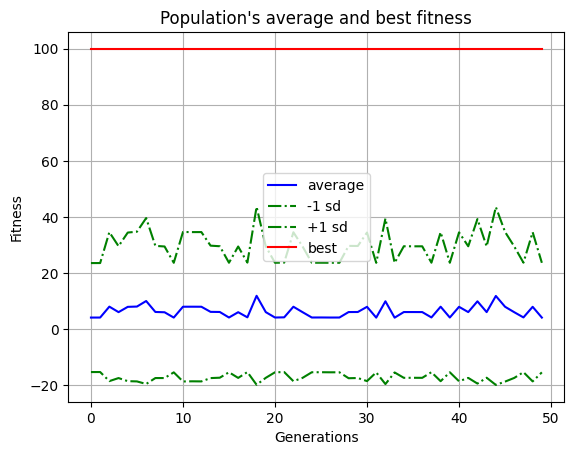

Subroutine Pango::Layout::set_text redefined at /usr/share/perl5/Gtk3.pm line 2260.
	require Gtk3.pm called at /usr/bin/shutter line 72
	Shutter::App::BEGIN() called at /usr/share/perl5/Gtk3.pm line 2260
	eval {...} called at /usr/share/perl5/Gtk3.pm line 2260
Subroutine Pango::Layout::set_markup redefined at /usr/share/perl5/Gtk3.pm line 2266.
	require Gtk3.pm called at /usr/bin/shutter line 72
	Shutter::App::BEGIN() called at /usr/share/perl5/Gtk3.pm line 2266
	eval {...} called at /usr/share/perl5/Gtk3.pm line 2266
GLib-GObject-CRITICAL **: g_boxed_type_register_static: assertion 'g_type_from_name (name) == 0' failed at /usr/lib/x86_64-linux-gnu/perl5/5.30/Glib/Object/Introspection.pm line 110.
 at /usr/share/perl5/Gtk3.pm line 489.
	Gtk3::import("Gtk3", "-init") called at /usr/bin/shutter line 72
	Shutter::App::BEGIN() called at /usr/bin/shutter line 72
	eval {...} called at /usr/bin/shutter line 72
GLib-CRITICAL **: g_once_init_leave: assertion 'result != 0' failed at /usr/lib/x86

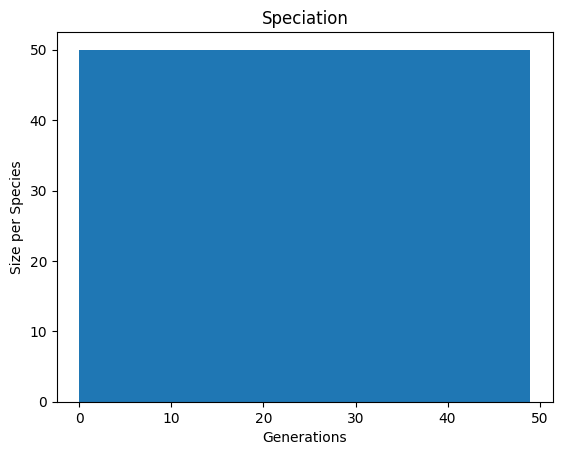

In [22]:
winner = run("laberint.config")

Finalment avaluem el millor cromosoma i el posem en marxa

In [34]:
# Avaluem el guanyador
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "laberint.config")

winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
fitness(winner_net, 60, real_time=True)

Using random seed: 614952


  0%|          | 0/8000 [00:00<?, ?it/s]

Simulation stopped at: 00:00:14.70; speed 0.98 x real time


99.9087853604821

In [36]:
display("avg_fitness.svg")

'avg_fitness.svg'

El resultat ha segut molt satisfactori, el robot ha aprés a arribar a la destinació en un temps raonable i explorant l'entorn. 

Guardarem el millor cromosoma per poder-lo utilitzar en el futur

In [ ]:
with open("winner.pkl", "wb") as f:    
    import pickle
    
    pickle.dump(winner, f)

Carreguem el model per a comprovar que funciona correctament

In [ ]:
# carreguem el cromosoma guanyador

with open("winner.pkl", "rb") as f:
    import pickle
    winner = pickle.load(f)
    f.close()

# Avaluem el guanyador
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "laberint.config")
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
fitness(winner_net, 30, real_time=True)

Using random seed: 6926549


  0%|          | 0/300 [00:00<?, ?it/s]

Simulation stopped at: 00:00:30.00; speed 0.96 x real time


2.785